<center> <a href="https://colab.research.google.com/github/DCDPUAEM/DCDP_2022/blob/main/05 Deep Learning/notebooks/13-SOM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> </center>

<h1>SOM: Self-Organizing Map</h1>

En esta notebook se ilustra brevemente el funcionamiento y algunos usos de las SOMs. Para esto, usaremos el módulo `minisom`. 

In [1]:
!pip install -q minisom

Referencias:

* Berglund, E., & Sitte, J. (2006). The parameterless self-organizing map algorithm. IEEE Transactions on neural networks, 17(2), 305-316.
* Yin, H. (2008). The self-organizing maps: Background, theories, extensions and applications. In Studies in Computational Intelligence. Stud. Comput. Intell. (Vol. 115, pp. 715-762). Springer Nature. https://doi.org/10.1007/978-3-540-78293-3_17

# Ejemplo 1: Demostración básica

En este ejemplo analizaremos datos de tarjetas de crédito de direferentes clientes, los datos están divididos en dos clases. En este ejemplo ilustraremos el funcionamiento de una SOM.

Traemos la carpeta desde Github

In [83]:
#@title
!apt-get -qq install > /dev/null subversion

!svn checkout "https://github.com/DCDPUAEM/DCDP_2022/trunk/05%20Deep%20Learning/data/"

A    data/airline-passengers.csv
A    data/cc-a.csv
A    data/diabetes.csv
A    data/ecg.csv
A    data/housing.data
A    data/img.png
A    data/mnist_biases1.npy
A    data/mnist_biases2.npy
A    data/mnist_weights1.npy
A    data/mnist_weights2.npy
Checked out revision 142.


In [84]:
import pandas as pd

df = pd.read_csv('data/cc-a.csv')
df

,CustomerID,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,Class
0,15776156,1,22.08,11.460,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,15739548,0,22.67,7.000,2,8,4,0.165,0,0,0,0,2,160,1,0
2,15662854,0,29.58,1.750,1,4,4,1.250,0,0,0,1,2,280,1,0
3,15687688,0,21.67,11.500,1,5,3,0.000,1,1,11,1,2,0,1,1
4,15715750,1,20.17,8.170,2,6,4,1.960,1,1,14,0,2,60,159,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,15808223,1,31.57,10.500,2,14,4,6.500,1,0,0,0,2,0,1,1
686,15769980,1,20.67,0.415,2,8,4,0.125,0,0,0,0,2,0,45,0
687,15675450,0,18.83,9.540,2,6,4,0.085,1,0,0,0,2,100,1,1
688,15776494,0,27.42,14.500,2,14,8,3.085,1,1,1,0,2,120,12,1


Separamos en el conjunto de datos y el vector de etiquetas

In [85]:
X = df.values[:,1:14]
y = df.values[:, -1]

print(f"Forma de los datos {X.shape}")

y = y.astype(int)

Forma de los datos (690, 13)


Re-escalamos cada columna para que los valores estén en $[0,1]$.

In [87]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()
X = sc.fit_transform(X)

Definimos los parámetros del SOM

In [86]:
som_grid_rows = 20
som_grid_columns = 20
iterations = 20000
sigma = 1 # Efecto en el alcance del efecto de actualización a los vecinos, mientras más neuronas, mayor es sigma
learning_rate = 0.5

Definimos el SOM

In [88]:
from minisom import MiniSom

som = MiniSom(x = som_grid_rows, y = som_grid_columns, input_len=X.shape[1], sigma=sigma, 
              learning_rate=learning_rate)

# Inicializamos los pesos aleatoriamente
som.random_weights_init(X)

Entrenamos la red

In [89]:
som.train_random(X, iterations)

Veamos la matriz de pesos

In [90]:
pesos = som.get_weights()
print(pesos.shape)

(20, 20, 13)


El mapa de distancias indica, en promedio, la distancia de cada celda con sus vecinos. Es una matriz de rows$\times$columns.

In [91]:
dm = som.distance_map()
dm.shape

(20, 20)

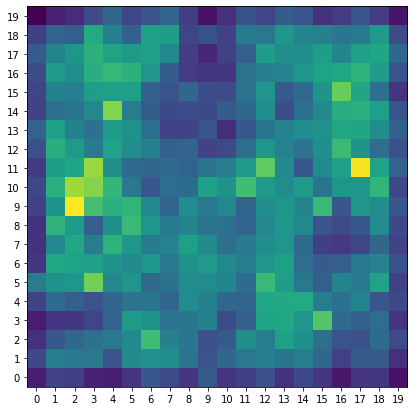

In [92]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))
plt.imshow(som.distance_map().T,origin='lower')
plt.xticks(range(som_grid_rows))
plt.yticks(list(range(som_grid_columns)))
plt.show()

Para cada dato $x_j$, podemos obtener la neurona ganadora de la siguiente forma:

In [93]:
som.winner(X[0])

(15, 2)

También podemos visualizar la asignación explícita de cada punto en su respectiva celda.

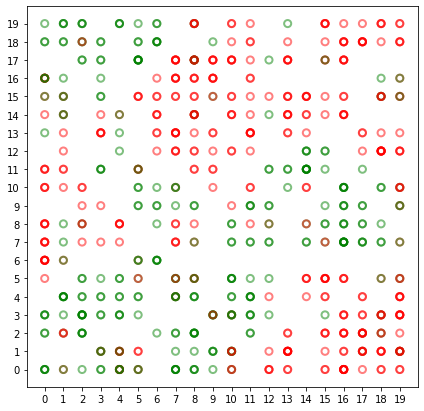

In [94]:
colors = ['r', 'g']

plt.figure(figsize=(7,7))
for i, x in enumerate(X):
    w = som.winner(x)
    plt.scatter(w[0],
        w[1],
        marker = 'o',
        edgecolors = colors[y[i]],
        facecolors = 'None',
        s = 50,
        linewidths = 2,
        alpha=0.5)
# plt.imshow(som.distance_map().T,origin='lower',cmap='Greys')
plt.xticks(range(som_grid_rows))
plt.yticks(list(range(som_grid_columns)))
plt.show()

# Ejemplo 2: Clasificación

En este ejemplo usaremos una SOM para la tarea de clasificar el dataset Iris.

In [13]:
import numpy as np
from sklearn.datasets import load_iris

data = load_iris()

X = data.data   # Matriz de features
y = data.target # Vector de etiquetas

print(f"Número de ejemplos: {X.shape[0]}")
print(f"Número de features por ejemplo: {X.shape[1]}")

Número de ejemplos: 150
Número de features por ejemplo: 4


Normalizamos de manera que cada vector 4-dimensional representando a cada individuo tenga norma 1. Aquí también podríamos intentar otras técnicas de normalización o re-escalamiento.

In [14]:
import pandas as pd

display(pd.DataFrame(X).head(3))

X_norm = np.apply_along_axis(lambda x: x/np.linalg.norm(x), 1, X)

display(pd.DataFrame(X_norm).head(3))

,0,1,2,3
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2


,0,1,2,3
0,0.803773,0.551609,0.220644,0.031521
1,0.828133,0.507020,0.236609,0.033801
2,0.805333,0.548312,0.222752,0.034269


Dividimos los datos en entrenamiento y prueba

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_norm, y, random_state=22, 
                                                    train_size=0.85)

print(f"Train size: {X_train.shape[0]}")
print(f"Test size: {X_test.shape[0]}")

Train size: 127
Test size: 23


Definimos el SOM y entrenamos

In [17]:
from minisom import MiniSom

som_grid_rows = 7
som_grid_columns = 7

som = MiniSom(som_grid_rows, som_grid_columns, 4, sigma=3, learning_rate=0.5, 
              neighborhood_function='triangle', random_seed=10)

som.pca_weights_init(X_train) # Inicializamos los pesos con PCA

# ---- Realizamos el entrenamiento ----
n_iterations = 500
som.train_random(X_train, n_iterations, verbose=False)

Visualicemos las representaciones. La posición dentro de cada celda no tiene ningún significado

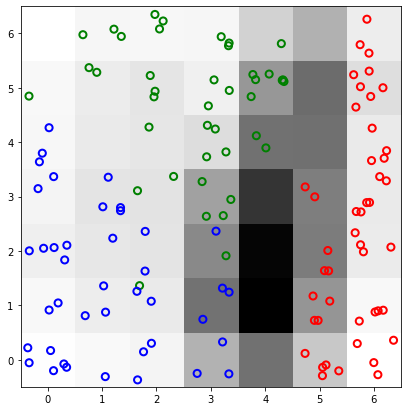

In [31]:
offset = lambda x: x + 0.75*(-0.5+np.random.rand())

colors = ['r','g','b']

plt.figure(figsize=(7,7))
for i, x in enumerate(X_train):
    w = som.winner(x)
    plt.scatter(offset(w[0]),
        offset(w[1]),
        marker = 'o',
        edgecolors = colors[y_train[i]],
        facecolors = 'None',
        s = 50,
        linewidths = 2)
plt.imshow(som.distance_map().T,origin='lower',cmap='Greys')
plt.xticks(range(som_grid_rows))
plt.yticks(list(range(som_grid_columns)))
plt.show()

El diccionario `labels_map` contiene los conteos de clase en cada celda.

In [19]:
som.labels_map(X_train,y_train)

defaultdict(list,
            {(0, 0): Counter({2: 6}),
             (0, 1): Counter({2: 2}),
             (0, 2): Counter({2: 5}),
             (0, 3): Counter({2: 2}),
             (0, 4): Counter({2: 3}),
             (0, 5): Counter({1: 1}),
             (1, 0): Counter({2: 1}),
             (1, 1): Counter({2: 3}),
             (1, 2): Counter({2: 1}),
             (1, 3): Counter({2: 4}),
             (1, 5): Counter({1: 2}),
             (1, 6): Counter({1: 3}),
             (2, 0): Counter({2: 3}),
             (2, 1): Counter({1: 1, 2: 2}),
             (2, 2): Counter({2: 2}),
             (2, 3): Counter({1: 2}),
             (2, 4): Counter({1: 1}),
             (2, 5): Counter({1: 3}),
             (2, 6): Counter({1: 3}),
             (3, 0): Counter({2: 3}),
             (3, 1): Counter({2: 3}),
             (3, 2): Counter({1: 1, 2: 1}),
             (3, 3): Counter({1: 4}),
             (3, 4): Counter({1: 4}),
             (3, 5): Counter({1: 3}),
             (3, 6):

Definimos una función que clasifique los datos con base en su representación dada por la SOM. Para esto, obtenemos los conteos de clase en cada celda para `X_train` y `y_train`. Definimos una clase default, calculando qué clase tiene más representantes, considerando todas las celdas. 

A continuación, para cada dato que queremos predecir su etiqueta usando el SOM consideramos la celda ganadora BMU correspondiente y

1. Le asignamos la clase mayoritaria de la celda para `X_train` y `y_train` (ver figura) si la celda contenia datos de `X_train`.
2. Le asignamos la clase default si la celda no contenia datos de `X_train`.

In [41]:
def clasificar(som, data, winmap):
    default_class = np.sum(list(winmap.values())).most_common()[0][0]
    result = []
    for d in data:
        win_position = som.winner(d)
        if win_position in winmap:
            result.append(winmap[win_position].most_common()[0][0])
        else:
            result.append(default_class)
    return result

Realizamos y evaluamos la tarea de clasificación.

In [44]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

winmap = som.labels_map(X_train, y_train)
predictions = clasificar(som, X_test, winmap)

print(f"Accuracy: {accuracy_score(y_test, predictions)}")
print(f"Recall: {recall_score(y_test, predictions,average='macro')}")
print(f"Precision: {precision_score(y_test, predictions,average='macro')}")
print(confusion_matrix(y_test, predictions))

Accuracy: 0.9130434782608695
Recall: 0.9259259259259259
Precision: 0.9111111111111111
[[5 0 0]
 [0 9 0]
 [1 1 7]]


Calculamos una matriz que tenga la clase mayoritaría de cada celda.

In [63]:
winmap = som.labels_map(X_train,y_train)

classes_cells = np.zeros_like(som.distance_map()) # La inicializamos en 0 porque la clase mayoritaria global es 0
for pair in winmap.keys():
    classes_cells[pair[0],pair[1]] = winmap[pair].most_common()[0][0]

classes_cells

array([[2., 2., 2., 2., 2., 1., 0.],
       [2., 2., 2., 2., 0., 1., 1.],
       [2., 2., 2., 1., 1., 1., 1.],
       [2., 2., 2., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.]])

Visualicemos las predicciones contra las etiquetas reales

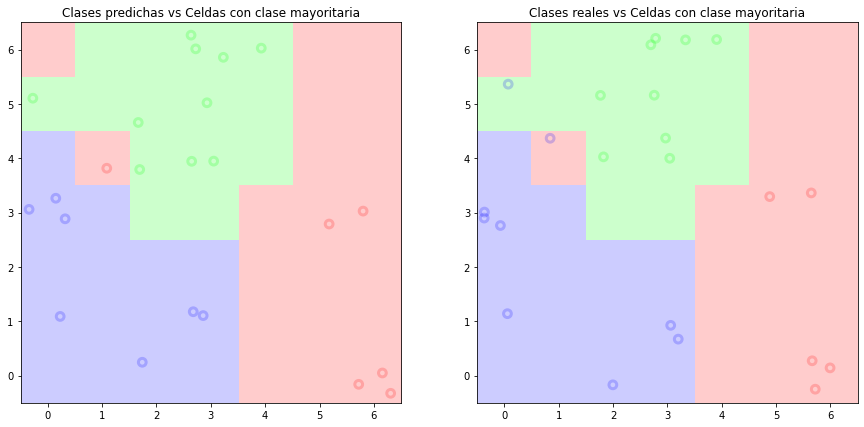

In [64]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# ---- Función para distribuir los puntos dentro de la celda ----
offset = lambda x: x + 0.75*(-0.5+np.random.rand())

alpha = 0.2
colors = [(1,0,0,alpha),
          (0,1,0,alpha),
          (0,0,1,alpha)]
CustomCmap = ListedColormap(colors)

plt.figure(figsize=(15,7))
# ----- Graficamos las predicciones de clase -----
ax = plt.subplot(1, 2, 1)
ax.title.set_text('Clases predichas vs Celdas con clase mayoritaria')
ax.imshow(classes_cells.T,origin='lower',cmap=CustomCmap)
for i, x in enumerate(X_test):
    w = som.winner(x)
    ax.scatter(offset(w[0]),
        offset(w[1]),
        marker = 'o',
        edgecolors = colors[predictions[i]],
        facecolors = 'None',
        s = 60,
        linewidths = 3)
ax.set_xticks(range(som_grid_rows))
ax.set_yticks(list(range(som_grid_columns)))
# ----- Graficamos las clases reales -----
ax = plt.subplot(1, 2, 2)
ax.title.set_text("Clases reales vs Celdas con clase mayoritaria")
ax.imshow(classes_cells.T,origin='lower',cmap=CustomCmap)
for i, x in enumerate(X_test):
    w = som.winner(x)
    ax.scatter(offset(w[0]),
        offset(w[1]),
        marker = 'o',
        edgecolors = colors[y_test[i]],
        facecolors = 'None',
        s = 60,
        linewidths = 3)
ax.set_xticks(range(som_grid_rows))
ax.set_yticks(list(range(som_grid_columns)))
plt.show()

# Ejemplo 3: Outlier Detection

En este ejemplo usaremos una SOM como herramienta de detección de outliers. La idea es un tanto similar al enfoque usado con los autoencoders.

Usaremos dos clusters dados por `make_blobs` y añadiremos ruido que será detectado como *outliers*.

In [65]:
from sklearn.datasets import make_blobs
from sklearn.preprocessing import scale
import numpy as np
import matplotlib.pyplot as plt

# ----- Proporción de outliers ----
outliers_percentage = 0.35
inliers = 300
outliers = int(inliers * outliers_percentage)

data = make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[.3, .3],
                  n_samples=inliers, random_state=0)[0] # No queremos el vector de etiquetas 'y'

Normalizamos los datos. De la documentación:

*Do not use scale unless you know what you are doing. A common mistake is to apply it to the entire data before splitting into training and test sets. This will bias the model evaluation because information would have leaked from the test set to the training set.* 

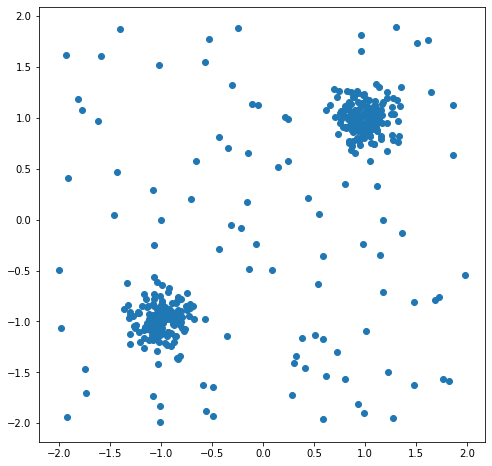

In [66]:
# ----- Normalizamos los datos para que tengan promedio 0 y desv. std. 1 -----
data = scale(data)
data = np.concatenate([data, 
                       (np.random.rand(outliers, 2)-.5)*4.])

# ----- Graficamos -----
plt.figure(figsize=(8, 8))
plt.scatter(data[:, 0], data[:, 1])
plt.show()

Definimos y entrenamos la SOM

In [70]:
som_grid_rows = 2
som_grid_columns = 1

som = MiniSom(som_grid_rows, som_grid_columns, data.shape[1], sigma=1, learning_rate=0.5,
              neighborhood_function='triangle', random_seed=10)

som.train(data, 100, random_order=False, verbose=False) 

/usr/local/lib/python3.7/dist-packages/minisom.py:160: UserWarning: Warning: sigma is too high for the dimension of the map.
  warn('Warning: sigma is too high for the dimension of the map.')


Una SOM crea un mapa de los datos de entrada en el espacio multidimensional al espacio menos dimensional que suele ser el espacio bidimensional llamado por el mapa de características de los datos. Para evaluar la calidad del mapa de características, se suelen utilizar dos indicadores: la calidad del aprendizaje y la calidad de la proyección. El indicador de calidad de aprendizaje se determina mediante la medición del **error de cuantificación** (QE). El indicador de calidad de proyección se determina mediante la medición del error topográfico (TE). Si los valores de QE y TE son pequeños, el mapa de características se considerará de buena calidad.

Definimos un umbral con base en el porcentaje de outliers que esperamos encontrar, en este caso, buscamos el percentil 70. `numpy.percentile` calcula el umbral de manera que el 70% de los errores de cuantificación queden por debajo del umbral. 

In [71]:
quantization_errors = np.linalg.norm(som.quantization(data) - data, axis=1)

error_treshold = np.percentile(quantization_errors, 
                               100*(1-outliers_percentage)+5)

print('Error treshold:', error_treshold)

Error treshold: 0.3397338714472679


Graficamos el histograma de los errores y el umbral.

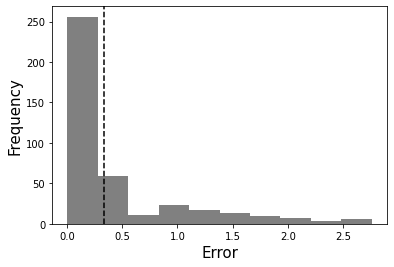

In [74]:
plt.figure()
plt.hist(quantization_errors, color='gray')
plt.axvline(error_treshold, color='black', linestyle='--')
plt.xlabel('Error', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.show()

Definimos un arreglo con los valores de verdad de la comparación 

$$\text{error_q}>\text{umbral}.$$

Es decir, este arreglo contiene evalua si cada dato es un *outlier*.

In [78]:
is_outlier = quantization_errors > error_treshold

print(quantization_errors[:5])
print(is_outlier[:5])

[0.16763476 0.30752088 0.22364363 0.05677474 0.27109566]
[False False False False False]


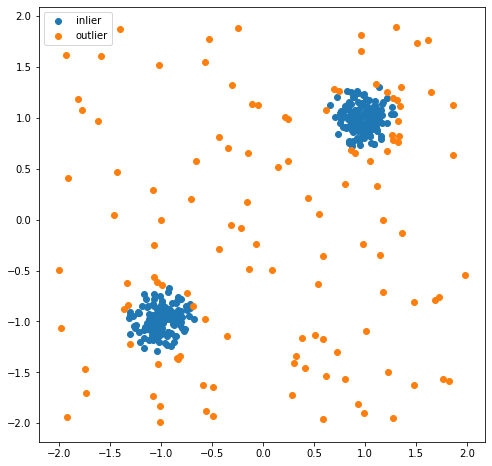

In [80]:
plt.figure(figsize=(8, 8))
plt.scatter(data[~is_outlier, 0], data[~is_outlier, 1],
            label='inlier')
plt.scatter(data[is_outlier, 0], data[is_outlier, 1],
            label='outlier')
plt.legend(loc='best')
plt.show()

En este ejemplo no nos interesa visualizar la representación 2-dimensional de los datos

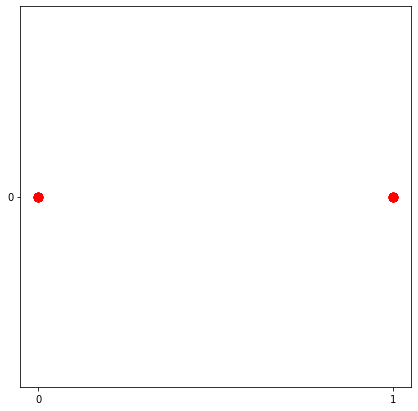

In [ ]:
import matplotlib.pyplot as plt
          

plt.figure(figsize=(7,7))
for i, x in enumerate(data):
    w = som.winner(x)
    plt.scatter(w[0],
        w[1],
        marker = 'o',
        color = 'red',
        s = 50,
        linewidths = 2,
        alpha=0.5)
plt.xticks(range(som_grid_rows))
plt.yticks(list(range(som_grid_columns)))
plt.show()